# Inverse Transform Method: Theory and Implementation

This notebook provides a comprehensive introduction to the inverse transform method for random sampling, covering theoretical foundations, visual demonstrations, and practical implementations.

In [2]:
import time
from typing import Callable

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import gamma

from mc_lab._rng import as_generator
from mc_lab.inverse_transform import (
    InverseTransformSampler,
    NumericalInverseTransformSampler,
)

# Set style for consistent plots
plt.style.use("seaborn-v0_8-dark")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 11

# Color palette
COLORS = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499"]

# Fixed random seed for reproducibility
RANDOM_SEED = 42
rng = as_generator(RANDOM_SEED)

## 1. Theoretical Foundation

### The Fundamental Theorem

**The inverse transform method is universally applicable to both continuous and discrete distributions.**

If $U \sim \text{Uniform}(0,1)$ and $F$ is a CDF with inverse $F^{-1}$, then $F^{-1}(U)$ follows the distribution with CDF $F$.

### Critical Implementation Insight

**🔑 Key Advantage: The method reduces sampling from ANY arbitrary distribution to sampling from Uniform(0,1)**

This reduction is **fundamental to efficient random number generation** because:

- **Uniform sampling is simple**: Modern computers can generate high-quality uniform random numbers efficiently
- **Single source of randomness**: All distributions can be generated from one uniform generator
- **Deterministic transformation**: Given the same uniform input, you always get the same output
- **Quality preservation**: The quality of your target distribution samples depends only on the quality of your uniform generator
- **Implementation simplicity**: You only need to implement one good uniform generator, then use mathematical transformations for everything else

**This is why virtually all random number libraries work this way internally!**

### Mathematical Proof Sketch

For a random variable $X$ with CDF $F(x)$, we want to show:

$$P(F^{-1}(U) \leq x) = F(x)$$

**Proof:**
- Let $Y = F^{-1}(U)$ where $U \sim \text{Uniform}(0,1)$
- We need: $P(Y \leq x) = P(F^{-1}(U) \leq x)$
- Since $F$ is monotonic: $F^{-1}(U) \leq x \Leftrightarrow U \leq F(x)$
- Therefore: $P(F^{-1}(U) \leq x) = P(U \leq F(x)) = F(x)$

### Continuous vs. Discrete Distributions

**The method works identically for both types of distributions:**

#### Continuous Distributions
- **Examples**: Normal, Exponential, Gamma, Beta
- **CDF**: Smooth, strictly increasing function
- **Inverse CDF**: Well-defined for all $u \in (0,1)$
- **Implementation**: Direct application of $F^{-1}(u)$

#### Discrete Distributions  
- **Examples**: Binomial, Poisson, Geometric, Discrete Uniform
- **CDF**: Step function with jumps at discrete values
- **Inverse CDF**: Generalized inverse (quantile function)
- **Implementation**: $F^{-1}(u) = \min\{x : F(x) \geq u\}$

**Key Insight**: The fundamental theorem holds regardless of whether the distribution is continuous or discrete because it only requires the existence of a CDF and its generalized inverse.

### When the Method Works
- $F$ must be a valid CDF (monotonic non-decreasing, right-continuous)
- $F^{-1}$ must exist (at least as a generalized inverse)
- **Works for ANY distribution** - continuous, discrete, or mixed
- For practical implementation, we need either:
  - Analytical form of $F^{-1}$, or
  - Ability to compute $F$ efficiently for numerical inversion

### Why This Matters for Implementation

**The uniform-to-arbitrary reduction makes the inverse transform method critical because:**

1. **Architectural Simplicity**: Random number generators only need one high-quality uniform source
2. **Reproducibility**: Same uniform seed → same sequence for any distribution
3. **Quality Control**: Focus testing and validation on the uniform generator
4. **Portability**: Uniform generators work the same across platforms
5. **Efficiency**: Specialized uniform generators (like hardware RNGs) benefit all distributions

### References for uniform random number generation:
* Donald E. Knuth. The Art of Computer Programming, Volume 2: Seminumerical Algorithms (3rd ed.). Addison‑Wesley, 1997.
* James E. Gentle. Random Number Generation and Monte Carlo Methods (2nd ed.). Springer Series in Statistics, 2003.
* Pierre L’Ecuyer. Random Number Generation. In: Handbook of Computational Statistics (2nd ed.), eds. J.E. Gentle, W.K. Härdle, Y. Mori. Springer, 2012. 

## 2. Visual Demonstration: Step-by-Step Transformation

Let's visualize how uniform random samples are transformed into samples from a target distribution.

In [206]:
def visualize_inverse_transform(dist_name: str, dist_obj, n_samples: int = 100):
    """
    Create step-by-step visualization of the inverse transform process.

    This function demonstrates the complete inverse transform method by creating
    a 2x2 subplot showing each step of the transformation process from uniform
    random samples to samples from a target distribution.

    Parameters
    ----------
    dist_name : str
        Human-readable name of the target distribution for plot titles and labels.
        Example: "Exponential(λ=1.5)", "Normal(μ=0,σ=1)", "Beta(α=2,β=5)"
    dist_obj : scipy.stats distribution object
        A frozen distribution object from scipy.stats that provides cdf() and ppf()
        methods. Must support:
        - cdf(x): Cumulative distribution function
        - ppf(u): Percent point function (inverse CDF)
        - pdf(x): Probability density function
    n_samples : int, optional (default=100)
        Number of random samples to generate and visualize. Larger values
        provide smoother histograms but may make individual transformation
        points harder to see in the CDF plot.

    Returns
    -------
    None
        Displays a matplotlib figure with four subplots showing:
        1. Histogram of uniform random samples U ~ Uniform(0,1)
        2. CDF with transformation arrows showing F^(-1)(U) mapping
        3. Histogram of transformed samples from target distribution
        4. Comparison between sample histogram and theoretical PDF

    Notes
    -----
    - Uses the global `rng` generator for reproducible random sampling
    - Transformation arrows in subplot 2 show how uniform values map to
      target distribution values through the inverse CDF
    - The final subplot verifies that samples match the theoretical distribution

    Examples
    --------
    >>> import scipy.stats as stats
    >>> exp_dist = stats.expon(scale=2.0)
    >>> visualize_inverse_transform("Exponential(β=2.0)", exp_dist, 150)

    >>> normal_dist = stats.norm(loc=0, scale=1)
    >>> visualize_inverse_transform("Standard Normal", normal_dist, 200)
    """
    # Generate uniform samples
    u_samples = rng.uniform(0, 1, n_samples)

    # Transform using inverse CDF
    x_samples = dist_obj.ppf(u_samples)

    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Add overall title and subtitle
    fig.suptitle(
        f"Inverse Transform Method: From Uniform to {dist_name}",
        fontsize=16,
        fontweight="bold",
        y=0.98,
    )
    fig.text(
        0.5,
        0.94,
        "Four-Step Process: (1) Generate Uniform → (2) Apply Inverse CDF → (3) Obtain Target Samples → (4) Verify Distribution",
        ha="center",
        fontsize=12,
        style="italic",
        color="#444444",
    )

    # 1. Uniform samples
    ax1.hist(u_samples, bins=20, alpha=0.7, color=COLORS[0], edgecolor="black")
    ax1.set_title("Step 1: Uniform Random Samples U ~ Uniform(0,1)")
    ax1.set_xlabel("u")
    ax1.set_ylabel("Frequency")
    ax1.grid(True, alpha=0.3)

    # 2. CDF visualization
    x_range = np.linspace(dist_obj.ppf(0.001), dist_obj.ppf(0.999), 1000)
    cdf_values = dist_obj.cdf(x_range)
    ax2.plot(
        x_range, cdf_values, color=COLORS[1], linewidth=2, label=f"{dist_name} CDF"
    )

    # Show transformation for a few sample points
    sample_indices = np.linspace(0, len(u_samples) - 1, 8, dtype=int)
    for i in sample_indices:
        u_val = u_samples[i]
        x_val = x_samples[i]
        ax2.plot(
            [dist_obj.ppf(0.001), x_val, x_val],
            [u_val, u_val, 0],
            color=COLORS[5],
            linestyle="--",
            alpha=0.6,
            linewidth=1,
        )
        ax2.plot(x_val, u_val, "o", color=COLORS[5], markersize=6, alpha=0.8)

    ax2.set_title("Step 2: CDF and Inverse Transform Mapping")
    ax2.set_xlabel("x")
    ax2.set_ylabel("F(x)")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Transformed samples
    ax3.hist(x_samples, bins=20, alpha=0.7, color=COLORS[2], edgecolor="black")
    ax3.set_title(f"Step 3: Transformed Samples from {dist_name} Distribution")
    ax3.set_xlabel("x")
    ax3.set_ylabel("Frequency")
    ax3.grid(True, alpha=0.3)

    # 4. Comparison with theoretical PDF
    x_theory = np.linspace(min(x_samples), max(x_samples), 200)
    pdf_theory = dist_obj.pdf(x_theory)
    ax4.hist(
        x_samples,
        bins=20,
        density=True,
        alpha=0.7,
        color=COLORS[2],
        edgecolor="black",
        label="Samples",
    )
    ax4.plot(
        x_theory,
        pdf_theory,
        color=COLORS[6],
        linewidth=2,
        label=f"Theoretical {dist_name} PDF",
    )
    ax4.set_title("Step 4: Verification Against Theoretical Distribution")
    ax4.set_xlabel("x")
    ax4.set_ylabel("Density")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Adjust spacing to accommodate the title and subtitle
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

### Demonstrate with Exponential distribution


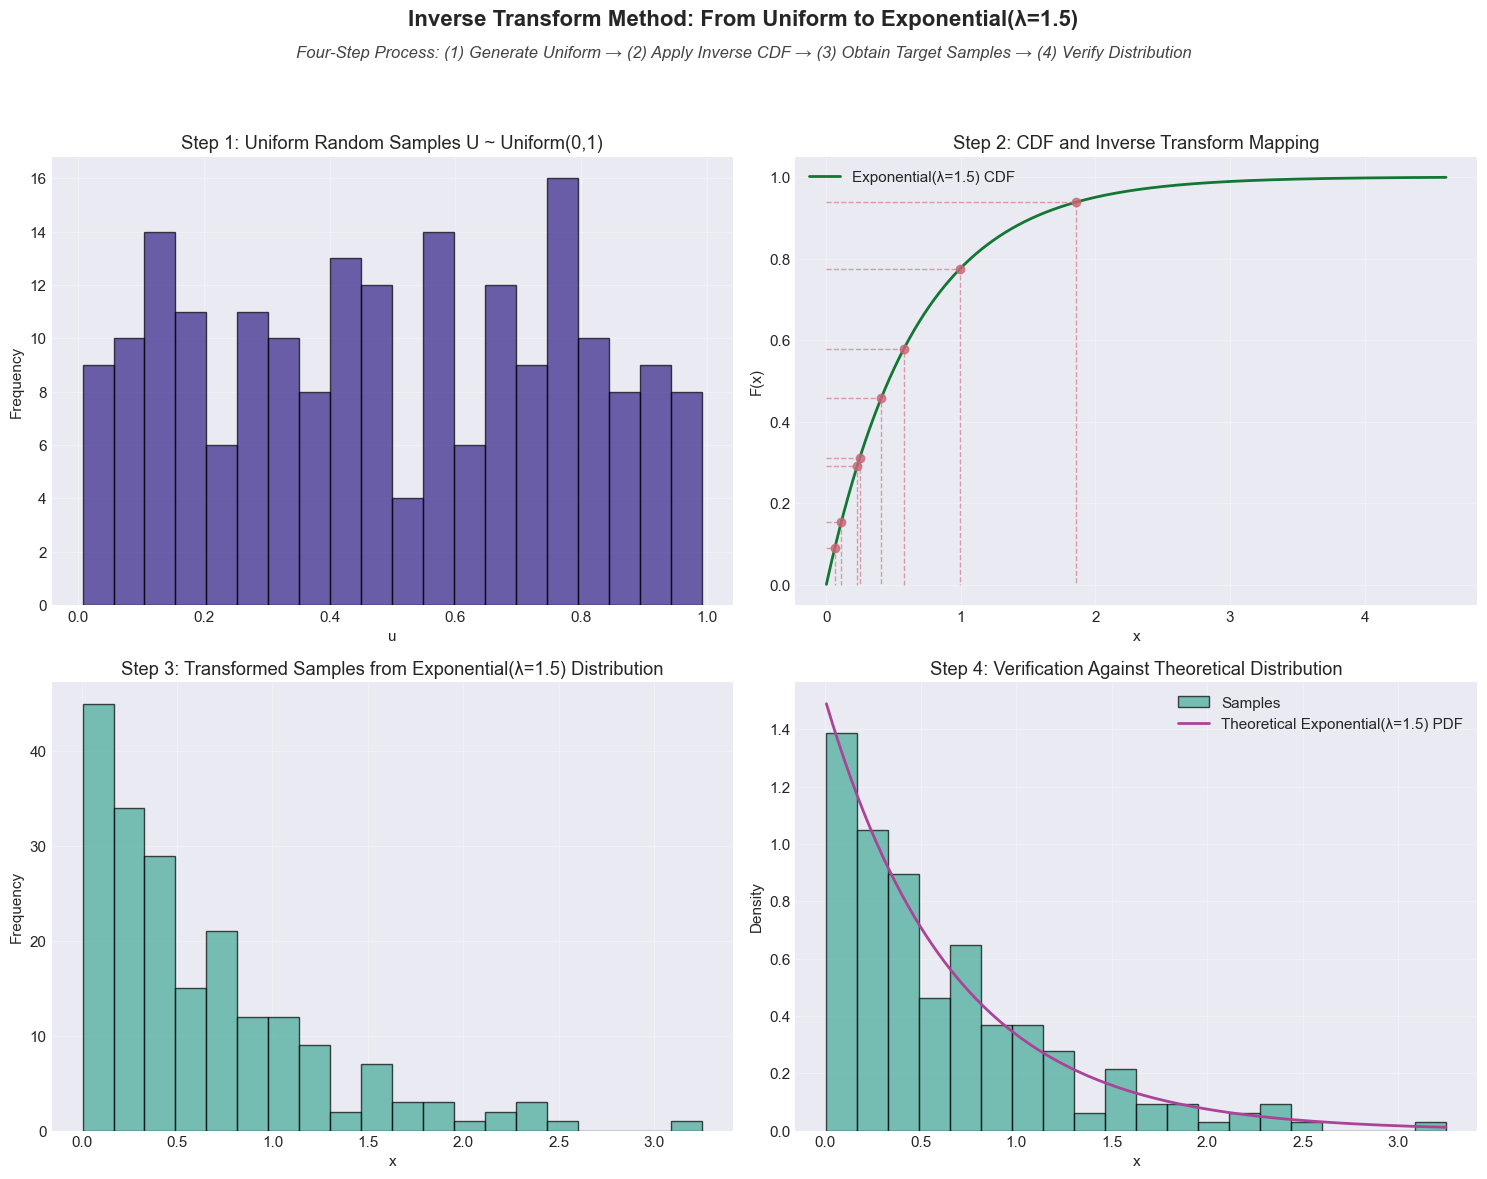

In [207]:
exp_dist = stats.expon(scale=1 / 1.5)
visualize_inverse_transform("Exponential(λ=1.5)", exp_dist, 200)

### Demonstrate with Weibull distribution

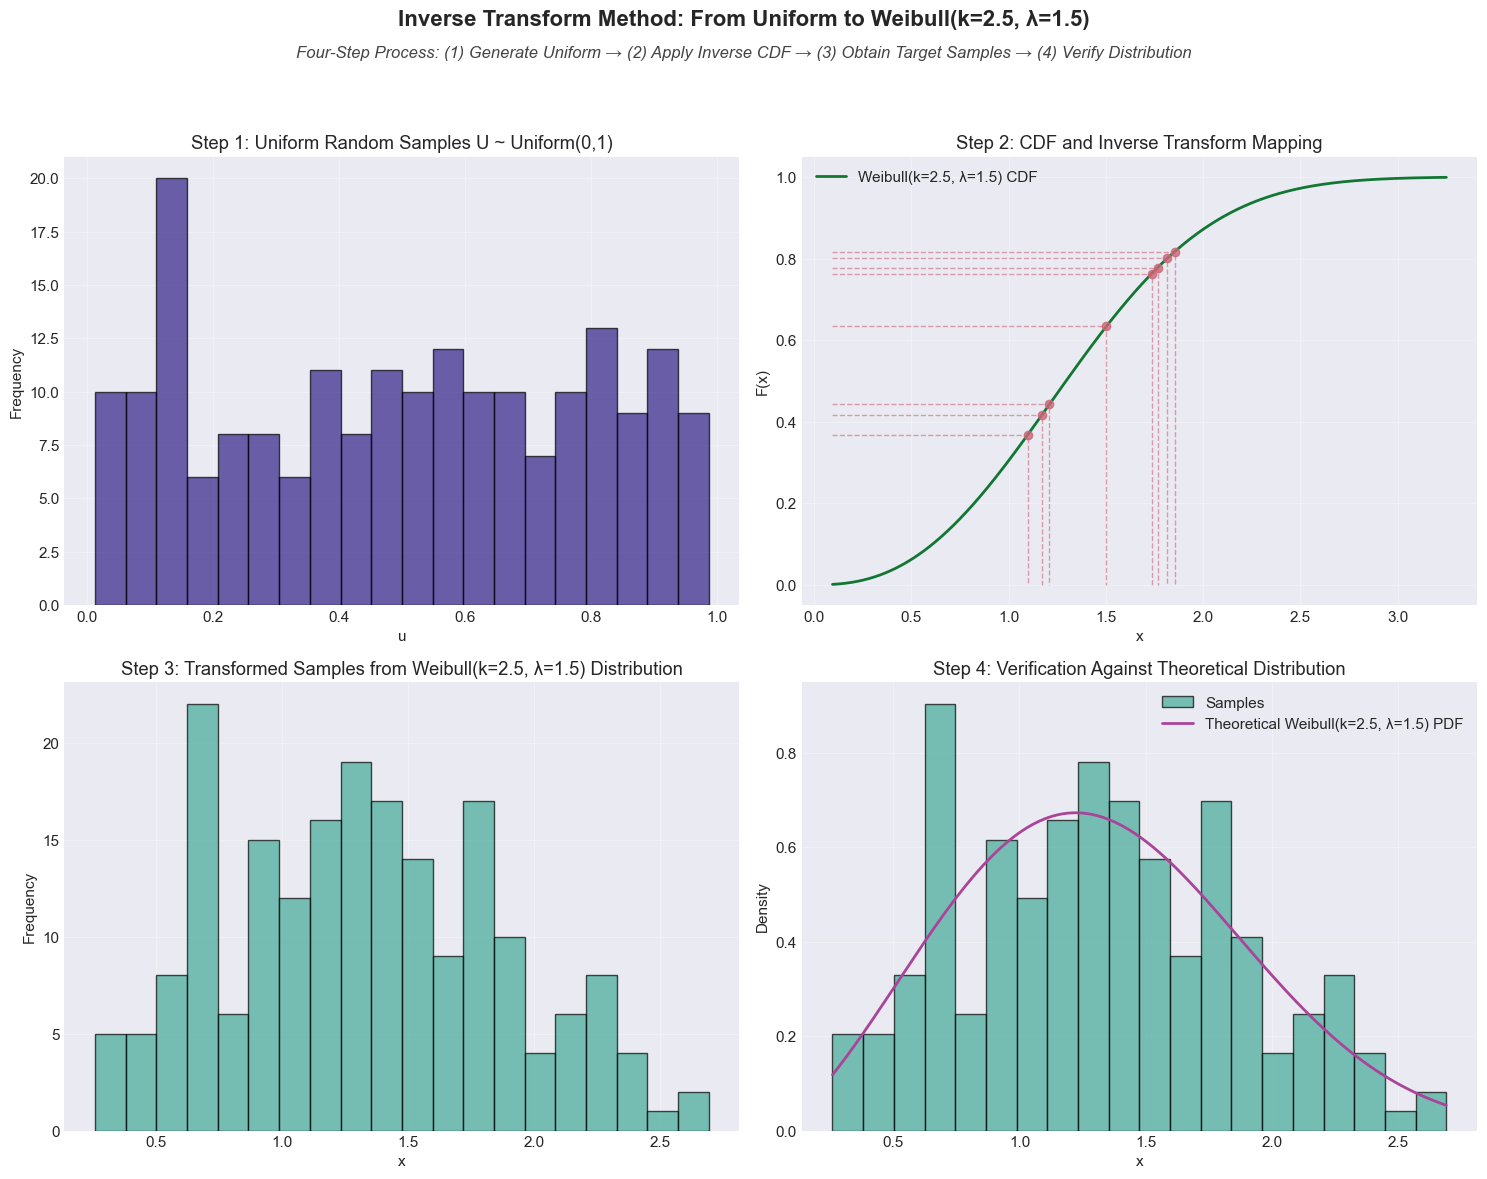

In [208]:
# Weibull distribution parameters
SHAPE = 2.5  # k parameter (shape)
SCALE = 1.5  # λ parameter (scale)
weibull_dist = stats.weibull_min(SHAPE, scale=SCALE)

visualize_inverse_transform("Weibull(k=2.5, λ=1.5)", weibull_dist, 200)

### Theoretical properties

In [209]:
# use the `gamma` function imported earlier: `from scipy.special import gamma`
theoretical_mean = SCALE * gamma(1 + 1 / SHAPE)
theoretical_variance = SCALE**2 * (gamma(1 + 2 / SHAPE) - (gamma(1 + 1 / SHAPE)) ** 2)
theoretical_std = np.sqrt(theoretical_variance)

print(f"Weibull distribution: shape={SHAPE}, scale={SCALE}")
print(f"Theoretical mean: {theoretical_mean:.3f}")
print(f"Theoretical std: {theoretical_std:.3f}")

# Sample sizes for comparison
N_SAMPLES = 10000
N_PERFORMANCE = 100000

Weibull distribution: shape=2.5, scale=1.5
Theoretical mean: 1.331
Theoretical std: 0.569


In [210]:
def method_1_direct_sampling(n: int, seed: int) -> np.ndarray:
    """
    Direct sampling from Weibull distribution using NumPy's built-in weibull function.

    This method uses NumPy's native Weibull random number generator, which is typically
    the most efficient approach for generating Weibull-distributed samples. NumPy's
    implementation uses a parameterization where weibull(a) generates samples from a
    Weibull distribution with shape parameter 'a' and unit scale, which we then scale
    by the desired scale parameter.

    Parameters
    ----------
    n : int
        Number of random samples to generate. Must be a positive integer.
    seed : int
        Random seed for reproducibility. This ensures that the same sequence of
        random numbers will be generated for the same seed value.

    Returns
    -------
    np.ndarray
        Array of n samples from the Weibull distribution with the specified
        shape and scale parameters (SHAPE and SCALE global variables).

    Notes
    -----
    NumPy's weibull function uses the parameterization:
    - Shape parameter: a (corresponds to our SHAPE parameter)
    - Scale parameter: Applied as a multiplier (corresponds to our SCALE parameter)

    The Weibull PDF is: f(x) = (k/λ) * (x/λ)^(k-1) * exp(-(x/λ)^k)
    where k is the shape parameter and λ is the scale parameter.

    This method is generally the fastest for Weibull sampling since it uses
    optimized C implementations within NumPy.

    Examples
    --------
    >>> samples = method_1_direct_sampling(1000, 42)
    >>> print(f"Generated {len(samples)} samples with mean {np.mean(samples):.3f}")
    """
    local_rng = np.random.default_rng(seed)
    # NumPy's weibull uses different parameterization: weibull(a) with scale applied separately
    return local_rng.weibull(SHAPE, n) * SCALE

In [211]:
def method_2_analytical_inverse(n: int, seed: int) -> np.ndarray:
    """
    Analytical inverse transform sampling using SciPy's percent point function (ppf).

    This method demonstrates the inverse transform method by explicitly generating
    uniform random variables and then applying the inverse cumulative distribution
    function (quantile function) to transform them into Weibull-distributed samples.
    SciPy's ppf function provides a high-accuracy implementation of the inverse CDF.

    Parameters
    ----------
    n : int
        Number of random samples to generate. Must be a positive integer.
    seed : int
        Random seed for reproducibility. This ensures that the same sequence of
        uniform random numbers, and thus the same transformed samples, will be
        generated for the same seed value.

    Returns
    -------
    np.ndarray
        Array of n samples from the Weibull distribution with the specified
        shape and scale parameters (from the global weibull_dist object).

    Notes
    -----
    This method explicitly implements the inverse transform theorem:
    If U ~ Uniform(0,1), then F^(-1)(U) follows the distribution with CDF F.

    Steps performed:
    1. Generate n uniform random variables U ~ Uniform(0,1)
    2. Apply the Weibull inverse CDF: X = F^(-1)(U)
    3. Return the transformed samples X

    SciPy's ppf (percent point function) is the inverse of the CDF and uses
    highly optimized numerical methods for accuracy. This approach is pedagogically
    valuable as it clearly demonstrates the inverse transform principle.

    Performance is generally good but slower than direct methods due to the
    two-step process (uniform generation + transformation).

    Examples
    --------
    >>> samples = method_2_analytical_inverse(1000, 42)
    >>> # Verify the transformation worked correctly
    >>> import scipy.stats as stats
    >>> ks_stat, p_value = stats.kstest(samples, weibull_dist.cdf)
    >>> print(f"KS test p-value: {p_value:.4f} (should be > 0.05)")
    """
    local_rng = np.random.default_rng(seed)
    u = local_rng.uniform(0, 1, n)
    return weibull_dist.ppf(u)

In [212]:
def method_3_closed_form_inverse(n: int, seed: int) -> np.ndarray:
    """
    Closed-form analytical inverse transform using the explicit Weibull inverse CDF formula.

    This method implements the inverse transform method using the mathematically
    derived closed-form expression for the Weibull inverse CDF. Unlike method 2,
    which relies on SciPy's numerical implementation, this method uses the exact
    analytical formula, providing both educational value and computational efficiency.

    Parameters
    ----------
    n : int
        Number of random samples to generate. Must be a positive integer.
    seed : int
        Random seed for reproducibility. This ensures that the same sequence of
        random numbers will be generated for the same seed value.

    Returns
    -------
    np.ndarray
        Array of n samples from the Weibull distribution with the specified
        shape and scale parameters (SHAPE and SCALE global variables).

    Notes
    -----
    The Weibull inverse CDF (quantile function) has a closed-form expression:
    F^(-1)(u) = λ * (-ln(1-u))^(1/k)

    where:
    - λ (lambda) is the scale parameter (SCALE)
    - k is the shape parameter (SHAPE)
    - u is a uniform random variable in [0,1]

    Mathematical derivation:
    Starting with the Weibull CDF: F(x) = 1 - exp(-(x/λ)^k)
    Solving F(x) = u for x:
    u = 1 - exp(-(x/λ)^k)
    exp(-(x/λ)^k) = 1 - u
    -(x/λ)^k = ln(1 - u)
    (x/λ)^k = -ln(1 - u)
    x/λ = (-ln(1 - u))^(1/k)
    x = λ * (-ln(1 - u))^(1/k)

    This method uses the MC-Lab InverseTransformSampler with the analytical
    inverse function, demonstrating how to implement custom inverse transforms
    for educational purposes.

    Advantages:
    - Exact mathematical implementation
    - Good performance for the Weibull distribution
    - Educational value in showing the explicit formula

    Examples
    --------
    >>> samples = method_3_closed_form_inverse(1000, 42)
    >>> # Verify against theoretical properties
    >>> theoretical_mean = SCALE * gamma(1 + 1/SHAPE)
    >>> sample_mean = np.mean(samples)
    >>> print(f"Sample mean: {sample_mean:.3f}, Theoretical: {theoretical_mean:.3f}")
    """

    # Weibull inverse CDF: F^(-1)(u) = λ * (-ln(1-u))^(1/k)
    def inverse_weibull(u):
        return SCALE * (-np.log(1 - u)) ** (1 / SHAPE)

    # Create inverse transform sampler with our analytical function
    sampler = InverseTransformSampler(inverse_weibull, random_state=seed)
    return sampler.sample(n)

In [213]:
def method_4_numerical_inverse(n: int, seed: int) -> np.ndarray:
    """
    Numerical inverse transform sampling using MC-Lab's numerical CDF inversion.

    This method demonstrates the most general approach to inverse transform sampling
    by numerically inverting the cumulative distribution function. It works with
    any continuous distribution where the CDF can be evaluated, even when no
    closed-form inverse exists. This showcases the flexibility and power of
    numerical inverse transform methods.

    Parameters
    ----------
    n : int
        Number of random samples to generate. Must be a positive integer.
    seed : int
        Random seed for reproducibility. This ensures that the same sequence of
        random numbers will be generated for the same seed value.

    Returns
    -------
    np.ndarray
        Array of n samples from the Weibull distribution with the specified
        shape and scale parameters (from the global weibull_dist object).

    Notes
    -----
    The NumericalInverseTransformSampler works by:
    1. Pre-computing the CDF at many points across the distribution support
    2. Building an interpolation table mapping CDF values to x values
    3. For each uniform random variable u, finding x such that F(x) ≈ u

    This approach is particularly valuable when:
    - No closed-form inverse CDF exists
    - High accuracy is required for complex distributions
    - The same distribution will be sampled from repeatedly (amortized setup cost)

    Configuration parameters:
    - x_range: Domain of the distribution (0.001 to 99.9th percentile)
    - Default interpolation method provides good speed/accuracy balance
    - Automatic handling of boundary conditions

    Performance characteristics:
    - Initial setup cost to build interpolation table
    - Fast sampling once table is constructed
    - Memory usage scales with interpolation resolution
    - Accuracy depends on interpolation density and method

    This method is slower than direct or analytical methods but demonstrates
    the universal applicability of inverse transform sampling to any distribution
    with a computable CDF.

    Examples
    --------
    >>> samples = method_4_numerical_inverse(1000, 42)
    >>> # Check that samples follow the expected distribution
    >>> from scipy import stats
    >>> ks_stat, p_value = stats.kstest(samples, weibull_dist.cdf)
    >>> print(f"Numerical method KS test p-value: {p_value:.4f}")

    >>> # Compare performance with analytical methods
    >>> import time
    >>> start = time.time()
    >>> large_sample = method_4_numerical_inverse(100000, 42)
    >>> duration = time.time() - start
    >>> print(f"Generated 100k samples in {duration:.3f} seconds")
    """
    # Create numerical inverse transform sampler
    sampler = NumericalInverseTransformSampler(
        weibull_dist.cdf, x_range=(0.001, weibull_dist.ppf(0.999)), random_state=seed
    )
    return sampler.sample(n)

In [214]:
def method_5_stratified_inverse_transform(n: int, seed: int) -> np.ndarray:
    """
    Stratified inverse transform sampling using MC-Lab's stratified sampler for variance reduction.

    This method demonstrates advanced Monte Carlo techniques by using stratified sampling
    to reduce variance in the generated samples. Stratified sampling divides the uniform
    [0,1] interval into equal-sized strata and generates exactly one sample from each
    stratum, ensuring better coverage of the probability space and reducing clustering
    that can occur with simple random sampling.

    Parameters
    ----------
    n : int
        Number of random samples to generate. Must be a positive integer.
    seed : int
        Random seed for reproducibility. This ensures that the same sequence of
        stratified uniform random numbers, and thus the same transformed samples,
        will be generated for the same seed value.

    Returns
    -------
    np.ndarray
        Array of n samples from the Weibull distribution with the specified
        shape and scale parameters, generated using stratified inverse transform.

    Notes
    -----
    Stratified sampling works by:
    1. Dividing [0,1] into k equal strata: [0, 1/k), [1/k, 2/k), ..., [(k-1)/k, 1]
    2. Generating exactly one uniform sample from each stratum
    3. Applying the inverse CDF to these stratified uniform samples

    This approach provides several advantages:
    - **Variance Reduction**: Lower variance than simple random sampling
    - **Better Coverage**: Ensures samples are spread across the entire distribution
    - **Deterministic Coverage**: Eliminates clustering and gaps in probability space
    - **Monte Carlo Efficiency**: Especially valuable for integration and estimation

    The method uses the MC-Lab StratifiedInverseTransformSampler which wraps
    the closed-form analytical inverse sampler with stratified uniform generation.
    This combines the speed of analytical inversion with the variance reduction
    benefits of stratification.

    Mathematical foundation:
    For the Weibull distribution, we use the same closed-form inverse:
    F^(-1)(u) = λ * (-ln(1-u))^(1/k)

    But instead of simple uniform samples, we use stratified samples that
    provide better coverage of the [0,1] interval.

    Performance characteristics:
    - Slightly slower than direct methods due to stratification overhead
    - Significantly better statistical properties for Monte Carlo applications
    - Ideal when sample quality is more important than raw generation speed

    Examples
    --------
    >>> samples = method_5_stratified_inverse_transform(1000, 42)
    >>> # Stratified samples should have lower variance than simple random sampling
    >>> # for Monte Carlo estimation tasks
    >>> print(f"Generated {len(samples)} stratified Weibull samples")
    """

    # Create the base analytical inverse sampler using closed-form formula
    def inverse_weibull(u):
        return SCALE * (-np.log(1 - u)) ** (1 / SHAPE)

    base_sampler = InverseTransformSampler(inverse_weibull, random_state=seed)

    # Wrap with stratified sampler for variance reduction
    # Use 10 strata by default for good balance between variance reduction and overhead
    from mc_lab.inverse_transform import StratifiedInverseTransformSampler

    stratified_sampler = StratifiedInverseTransformSampler(
        base_sampler, n_strata=10, random_state=seed
    )

    return stratified_sampler.sample(n)

In [215]:
def evaluate_method(
    method_func: Callable, method_name: str, n_samples: int, seed: int
) -> dict:
    """Evaluate a sampling method for accuracy and performance."""
    # Performance timing
    start_time = time.time()
    samples = method_func(n_samples, seed)
    end_time = time.time()
    runtime = end_time - start_time
    samples_per_sec = n_samples / runtime

    # Statistical evaluation
    sample_mean = np.mean(samples)
    sample_std = np.std(samples)

    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = stats.kstest(samples, weibull_dist.cdf)

    # Memory usage (approximate)
    memory_usage = samples.nbytes / (1024**2)  # MB

    return {
        "method": method_name,
        "sample_mean": sample_mean,
        "sample_std": sample_std,
        "theoretical_mean": theoretical_mean,
        "theoretical_std": theoretical_std,
        "ks_pvalue": ks_pvalue,
        "samples_per_sec": samples_per_sec,
        "memory_mb": memory_usage,
    }


# Evaluate all methods
methods = [
    (method_1_direct_sampling, "Direct (NumPy)"),
    (method_2_analytical_inverse, "Analytical (SciPy)"),
    (method_3_closed_form_inverse, "Closed-form Inverse"),
    (method_4_numerical_inverse, "Numerical Inverse"),
    (method_5_stratified_inverse_transform, "Stratified Inverse Transform"),
]

results = []
print("Evaluating methods (this may take a moment)...")

for method_func, method_name in methods:
    print(f"Testing {method_name}...")
    result = evaluate_method(method_func, method_name, N_PERFORMANCE, RANDOM_SEED)
    results.append(result)

print("Evaluation complete!")

Evaluating methods (this may take a moment)...
Testing Direct (NumPy)...
Testing Analytical (SciPy)...
Testing Closed-form Inverse...
Testing Numerical Inverse...
Testing Stratified Inverse Transform...
Evaluation complete!


In [216]:
# Create performance comparison table
df = pd.DataFrame(results)

# Format the table for display
formatted_df = df.copy()
formatted_df["sample_mean"] = formatted_df["sample_mean"].apply(lambda x: f"{x:.4f}")
formatted_df["sample_std"] = formatted_df["sample_std"].apply(lambda x: f"{x:.4f}")
formatted_df["theoretical_mean"] = formatted_df["theoretical_mean"].apply(
    lambda x: f"{x:.2f}"
)
formatted_df["theoretical_std"] = formatted_df["theoretical_std"].apply(
    lambda x: f"{x:.2f}"
)
formatted_df["ks_pvalue"] = formatted_df["ks_pvalue"].apply(lambda x: f"{x:.4f}")
formatted_df["samples_per_sec"] = formatted_df["samples_per_sec"].apply(
    lambda x: f"{x:,.0f}"
)
formatted_df["memory_mb"] = formatted_df["memory_mb"].apply(lambda x: f"{x:.2f}")

# Rename columns for display
formatted_df.columns = [
    "Method",
    "Sample Mean",
    "Sample Std",
    "Theoretical Mean",
    "Theoretical Std",
    "KS Test p-value",
    "Runtime (samples/sec)",
    "Memory Usage (MB)",
]

print("Performance Comparison Table:")
print("=" * 120)
print(formatted_df.to_string(index=False))
print("=" * 120)

print("\nInterpretation:")
print("- KS Test p-value > 0.05 indicates samples follow the expected distribution")
print("- Higher samples/sec indicates better performance")
print("- All methods should produce similar means and standard deviations")

Performance Comparison Table:
                      Method Sample Mean Sample Std Theoretical Mean Theoretical Std KS Test p-value Runtime (samples/sec) Memory Usage (MB)
              Direct (NumPy)      1.3325     0.5707             1.33            0.57          0.6794            60,271,648              0.76
          Analytical (SciPy)      1.3319     0.5695             1.33            0.57          0.3313            32,752,647              0.76
         Closed-form Inverse      1.3294     0.5677             1.33            0.57          0.8299            47,798,336              0.76
           Numerical Inverse      1.3292     0.5671             1.33            0.57          0.8301            14,972,171              0.76
Stratified Inverse Transform      1.3303     0.5688             1.33            0.57          0.9975            12,298,208              0.76

Interpretation:
- KS Test p-value > 0.05 indicates samples follow the expected distribution
- Higher samples/sec indicates 

## Summary and Key Takeaways

This notebook has demonstrated the theoretical foundations and practical applications of the inverse transform method:

### Key Theoretical Insights
1. **Fundamental Theorem**: $F^{-1}(U) \sim F$ when $U \sim \text{Uniform}(0,1)$
2. **Probability Integral Transform**: $F(X) \sim \text{Uniform}(0,1)$ when $X \sim F$
3. **Requirements**: Monotonic, invertible CDF

### Implementation Methods
1. **Direct**: NumPy's built-in implementation (typically fastest)
2. **Analytical**: SciPy's ppf function (exact, good performance)
3. **Closed-form**: Manual implementation of analytical inverse
4. **Numerical**: Flexible, works with any CDF, some overhead
5. **Stratified**: Variance reduction through stratified sampling

### Performance Characteristics
- Direct methods (NumPy) are typically fastest
- Analytical inverse transform (SciPy ppf) is competitive and exact
- Closed-form inverse is fast when analytical formula is simple
- Numerical methods have setup overhead but are very flexible
- Stratified sampling provides variance reduction at modest performance cost

### When to Use Inverse Transform
- Exact sampling requirements
- Variance reduction needs
- Quasi-Monte Carlo methods
- Coupling and reproducibility

The inverse transform method is a fundamental technique in Monte Carlo methods, providing both theoretical insights and practical sampling capabilities.

## Advanced Applications: Coupling and Reproducibility

### What is Coupling in Monte Carlo?

**Coupling** is a powerful technique in probability and Monte Carlo simulation where you generate samples from different distributions using the **same underlying random source** (uniform random numbers). This creates a controlled dependency between the samples that can be exploited for various purposes.

#### Why Inverse Transform Enables Coupling

The inverse transform method is **uniquely suited for coupling** because:

1. **Deterministic transformation**: $X = F^{-1}(U)$ is a deterministic function
2. **Same uniform input**: Using the same $U$ values for different distributions creates controlled correlation
3. **Monotonic relationship**: If $U_1 < U_2$, then $F^{-1}(U_1) \leq F^{-1}(U_2)$ for any distribution

#### Practical Applications of Coupling

**1. Variance Reduction in Comparative Studies**
```python
# Compare two different parameter settings using the same random source
u_samples = rng.uniform(0, 1, 1000)

# Same underlying randomness, different distributions
samples_dist1 = stats.weibull_min(2.0, scale=1.0).ppf(u_samples)  
samples_dist2 = stats.weibull_min(2.5, scale=1.2).ppf(u_samples)

# The difference has lower variance than independent sampling
difference = samples_dist2 - samples_dist1
```

**2. Sensitivity Analysis**
- Use the same uniform sequence to test how changes in parameters affect outcomes
- Isolates the effect of parameter changes from random noise
- Essential for fair A/B testing in simulations

**3. Antithetic Variates**
```python
# Generate correlated samples for variance reduction
u_samples = rng.uniform(0, 1, 1000)
samples_1 = dist.ppf(u_samples)      # Original samples
samples_2 = dist.ppf(1 - u_samples)  # Antithetic samples (negatively correlated)

# Combined estimate has lower variance
combined_estimate = (f(samples_1) + f(samples_2)) / 2
```

**4. Path Coupling in MCMC**
- Start multiple Markov chains from different initial states
- Use the same uniform random numbers for proposal steps
- Chains will eventually "couple" (meet) and then evolve identically
- Provides rigorous stopping criteria for MCMC convergence

### Reproducibility Benefits

**Deterministic Relationships**: The inverse transform creates a **bijective mapping** between uniform inputs and distribution outputs:
- Same seed → Same uniform sequence → Same distribution samples
- Perfect reproducibility across platforms and implementations
- Enables debugging and validation of complex Monte Carlo procedures

**Cross-Distribution Reproducibility**: 
- The same uniform sequence can generate reproducible samples from multiple distributions
- Enables fair comparison between different modeling approaches
- Critical for scientific reproducibility in computational studies

### Mathematical Foundation

For coupling to work effectively, we need:

1. **Order preservation**: $u_1 < u_2 \Rightarrow F^{-1}(u_1) \leq F^{-1}(u_2)$
2. **Deterministic mapping**: $F^{-1}$ is a function (single-valued)
3. **Uniform marginals**: Each $F^{-1}(U)$ follows the correct marginal distribution

The inverse transform method satisfies all these requirements naturally, making it the **gold standard for coupling in Monte Carlo methods**.

### Example: Coupling for Parameter Sensitivity

Parameter Sensitivity Analysis: Weibull Mean Comparison
Distribution 1: shape=2.0, scale=1.0
Distribution 2: shape=2.5, scale=1.2

Theoretical difference in means: 0.1785

Independent sampling:
  Mean difference estimate: 0.1783
  Standard error: 0.0063

Coupled sampling:
  Mean difference estimate: 0.1785
  Standard error: 0.0003

Variance reduction from coupling: 99.7%


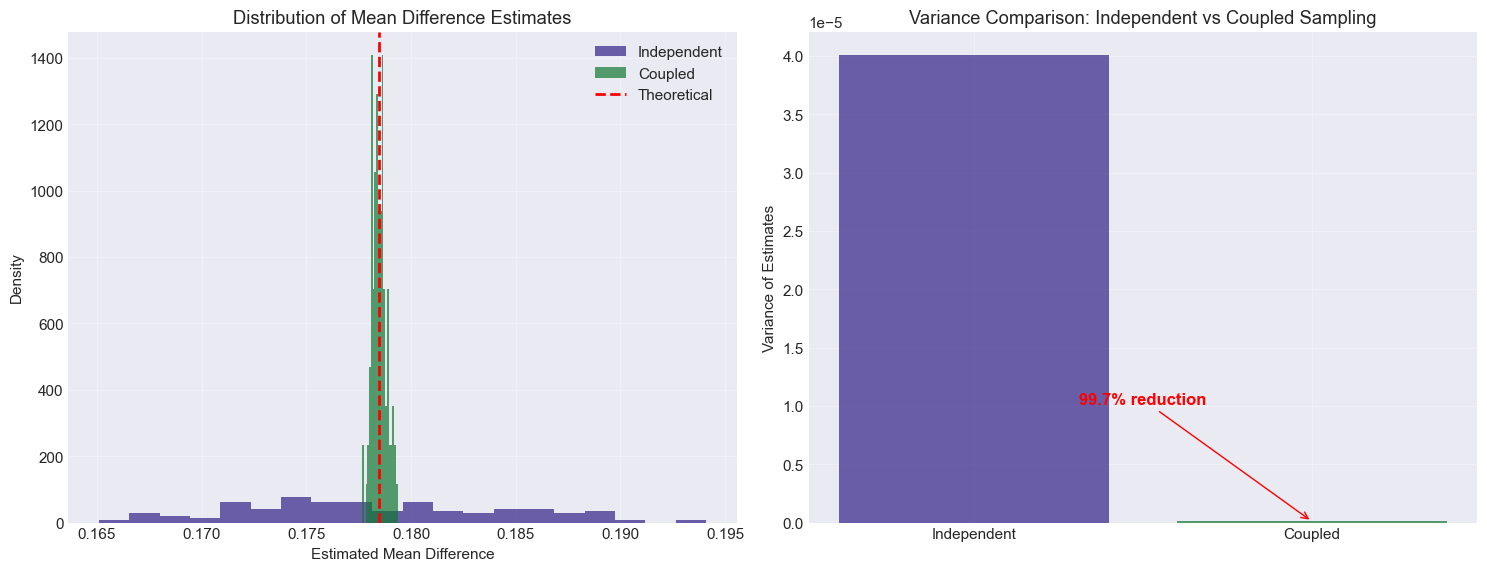

In [ ]:
def demonstrate_coupling_for_sensitivity():
    """
    Demonstrate how coupling reduces variance in parameter sensitivity analysis.

    This example shows how using the same uniform random numbers to sample
    from distributions with different parameters gives much more precise
    estimates of the difference between them.
    """
    n_samples = 10000
    n_replications = 100

    # Parameters for two Weibull distributions
    shape1, scale1 = 2.0, 1.0
    shape2, scale2 = 2.5, 1.2

    dist1 = stats.weibull_min(shape1, scale=scale1)
    dist2 = stats.weibull_min(shape2, scale=scale2)

    # Method 1: Independent sampling (traditional approach)
    independent_differences = []
    for _ in range(n_replications):
        samples1 = dist1.rvs(n_samples, random_state=rng)
        samples2 = dist2.rvs(n_samples, random_state=rng)
        mean_diff = np.mean(samples2) - np.mean(samples1)
        independent_differences.append(mean_diff)

    # Method 2: Coupled sampling (same uniform source)
    coupled_differences = []
    for _ in range(n_replications):
        # Use same uniform random numbers for both distributions
        u_samples = rng.uniform(0, 1, n_samples)
        samples1 = dist1.ppf(u_samples)
        samples2 = dist2.ppf(u_samples)
        mean_diff = np.mean(samples2) - np.mean(samples1)
        coupled_differences.append(mean_diff)

    # Compare variance reduction
    independent_var = np.var(independent_differences)
    coupled_var = np.var(coupled_differences)
    variance_reduction = (independent_var - coupled_var) / independent_var * 100

    # Theoretical difference in means
    theoretical_diff = (scale2 * gamma(1 + 1 / shape2)) - (
        scale1 * gamma(1 + 1 / shape1)
    )

    print("Parameter Sensitivity Analysis: Weibull Mean Comparison")
    print(f"Distribution 1: shape={shape1}, scale={scale1}")
    print(f"Distribution 2: shape={shape2}, scale={scale2}")
    print(f"\nTheoretical difference in means: {theoretical_diff:.4f}")
    print("\nIndependent sampling:")
    print(f"  Mean difference estimate: {np.mean(independent_differences):.4f}")
    print(f"  Standard error: {np.std(independent_differences):.4f}")
    print("\nCoupled sampling:")
    print(f"  Mean difference estimate: {np.mean(coupled_differences):.4f}")
    print(f"  Standard error: {np.std(coupled_differences):.4f}")
    print(f"\nVariance reduction from coupling: {variance_reduction:.1f}%")

    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot distributions of difference estimates
    ax1.hist(
        independent_differences,
        bins=20,
        alpha=0.7,
        color=COLORS[0],
        label="Independent",
        density=True,
    )
    ax1.hist(
        coupled_differences,
        bins=20,
        alpha=0.7,
        color=COLORS[1],
        label="Coupled",
        density=True,
    )
    ax1.axvline(
        theoretical_diff, color="red", linestyle="--", linewidth=2, label="Theoretical"
    )
    ax1.set_xlabel("Estimated Mean Difference")
    ax1.set_ylabel("Density")
    ax1.set_title("Distribution of Mean Difference Estimates")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot variance comparison
    methods = ["Independent", "Coupled"]
    variances = [independent_var, coupled_var]
    _ = ax2.bar(methods, variances, color=[COLORS[0], COLORS[1]], alpha=0.7)
    ax2.set_ylabel("Variance of Estimates")
    ax2.set_title("Variance Comparison: Independent vs Coupled Sampling")
    ax2.grid(True, alpha=0.3)

    # Add variance reduction annotation
    ax2.annotate(
        f"{variance_reduction:.1f}% reduction",
        xy=(1, coupled_var),
        xytext=(0.5, coupled_var + independent_var / 4),
        arrowprops=dict(arrowstyle="->", color="red"),
        fontsize=12,
        ha="center",
        color="red",
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()


# Run the demonstration
demonstrate_coupling_for_sensitivity()

/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_79858/4242814811.py:21: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sobol_uniform = sobol_sampler.random(n_samples).flatten()


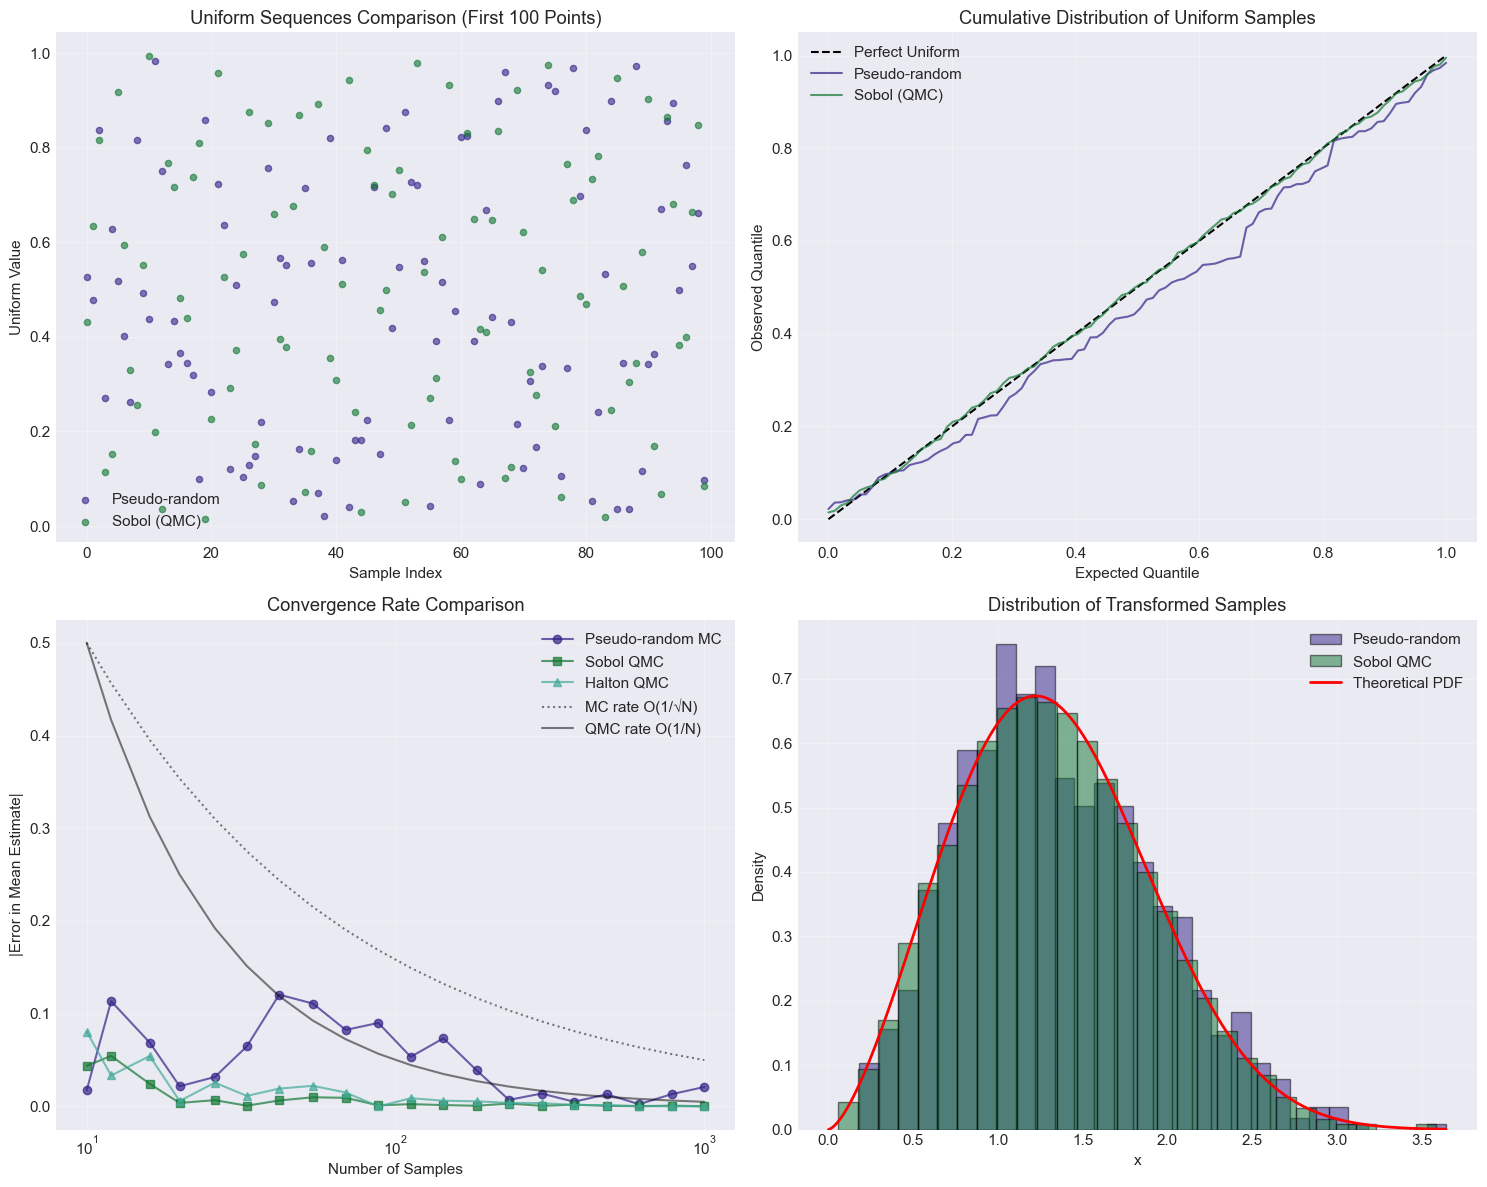

Quasi-Monte Carlo vs Standard Monte Carlo Results:
True mean: 1.330896
Random MC final estimate: 1.351869 (error: 0.020973)
Sobol QMC final estimate: 1.330651 (error: 0.000244)
Halton QMC final estimate: 1.330993 (error: 0.000097)

Convergence improvement (lower is better):
  Random MC: 1.0x better than Random MC
  Sobol QMC: 85.8x better than Random MC
  Halton QMC: 216.6x better than Random MC


In [218]:
def demonstrate_quasi_monte_carlo():
    """
    Demonstrate quasi-Monte Carlo methods using low-discrepancy sequences.

    This example shows how the inverse transform method enables the use of
    deterministic, low-discrepancy sequences instead of random numbers,
    leading to faster convergence in Monte Carlo integration.
    """
    try:
        from scipy.stats import qmc

        # Parameters for demonstration
        n_samples = 1000

        # Generate three types of uniform sequences
        # 1. Pseudo-random (standard Monte Carlo)
        random_uniform = rng.uniform(0, 1, n_samples)

        # 2. Sobol sequence (quasi-Monte Carlo)
        sobol_sampler = qmc.Sobol(d=1, scramble=True, seed=RANDOM_SEED)
        sobol_uniform = sobol_sampler.random(n_samples).flatten()

        # 3. Halton sequence (quasi-Monte Carlo)
        halton_sampler = qmc.Halton(d=1, scramble=True, seed=RANDOM_SEED)
        halton_uniform = halton_sampler.random(n_samples).flatten()

        # Transform all sequences to Weibull distribution using inverse transform
        weibull_random = weibull_dist.ppf(random_uniform)
        weibull_sobol = weibull_dist.ppf(sobol_uniform)
        weibull_halton = weibull_dist.ppf(halton_uniform)

        # Compare convergence of mean estimation
        sample_sizes = np.logspace(1, 3, 20, dtype=int)  # From 10 to 1000 samples

        # Calculate running means for each method
        random_means = [np.mean(weibull_random[:n]) for n in sample_sizes]
        sobol_means = [np.mean(weibull_sobol[:n]) for n in sample_sizes]
        halton_means = [np.mean(weibull_halton[:n]) for n in sample_sizes]

        # Theoretical mean for comparison
        true_mean = SCALE * gamma(1 + 1 / SHAPE)

        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Compare uniform sequences
        ax1.scatter(
            range(100),
            random_uniform[:100],
            alpha=0.6,
            s=20,
            color=COLORS[0],
            label="Pseudo-random",
        )
        ax1.scatter(
            range(100),
            sobol_uniform[:100],
            alpha=0.6,
            s=20,
            color=COLORS[1],
            label="Sobol (QMC)",
        )
        ax1.set_title("Uniform Sequences Comparison (First 100 Points)")
        ax1.set_xlabel("Sample Index")
        ax1.set_ylabel("Uniform Value")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Show discrepancy visualization
        sorted_random = np.sort(random_uniform[:100])
        sorted_sobol = np.sort(sobol_uniform[:100])
        expected_uniform = np.linspace(0, 1, 100)

        ax2.plot(expected_uniform, expected_uniform, "k--", label="Perfect Uniform")
        ax2.plot(
            expected_uniform,
            sorted_random,
            color=COLORS[0],
            alpha=0.7,
            label="Pseudo-random",
        )
        ax2.plot(
            expected_uniform,
            sorted_sobol,
            color=COLORS[1],
            alpha=0.7,
            label="Sobol (QMC)",
        )
        ax2.set_title("Cumulative Distribution of Uniform Samples")
        ax2.set_xlabel("Expected Quantile")
        ax2.set_ylabel("Observed Quantile")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Convergence comparison
        ax3.semilogx(
            sample_sizes,
            np.abs(np.array(random_means) - true_mean),
            "o-",
            color=COLORS[0],
            label="Pseudo-random MC",
            alpha=0.7,
        )
        ax3.semilogx(
            sample_sizes,
            np.abs(np.array(sobol_means) - true_mean),
            "s-",
            color=COLORS[1],
            label="Sobol QMC",
            alpha=0.7,
        )
        ax3.semilogx(
            sample_sizes,
            np.abs(np.array(halton_means) - true_mean),
            "^-",
            color=COLORS[2],
            label="Halton QMC",
            alpha=0.7,
        )

        # Add theoretical convergence rates
        mc_rate = 0.5 / np.sqrt(sample_sizes) * np.sqrt(sample_sizes[0])  # O(1/√N)
        qmc_rate = 0.5 / sample_sizes * sample_sizes[0]  # O(1/N)
        ax3.semilogx(sample_sizes, mc_rate, "k:", alpha=0.5, label="MC rate O(1/√N)")
        ax3.semilogx(sample_sizes, qmc_rate, "k-", alpha=0.5, label="QMC rate O(1/N)")

        ax3.set_xlabel("Number of Samples")
        ax3.set_ylabel("|Error in Mean Estimate|")
        ax3.set_title("Convergence Rate Comparison")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 4. Distribution comparison
        ax4.hist(
            weibull_random,
            bins=30,
            alpha=0.5,
            density=True,
            color=COLORS[0],
            label="Pseudo-random",
            edgecolor="black",
        )
        ax4.hist(
            weibull_sobol,
            bins=30,
            alpha=0.5,
            density=True,
            color=COLORS[1],
            label="Sobol QMC",
            edgecolor="black",
        )

        # Theoretical PDF
        x_theory = np.linspace(0, max(weibull_random.max(), weibull_sobol.max()), 200)
        pdf_theory = weibull_dist.pdf(x_theory)
        ax4.plot(
            x_theory, pdf_theory, color="red", linewidth=2, label="Theoretical PDF"
        )

        ax4.set_xlabel("x")
        ax4.set_ylabel("Density")
        ax4.set_title("Distribution of Transformed Samples")
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print numerical results
        print("Quasi-Monte Carlo vs Standard Monte Carlo Results:")
        print("=" * 60)
        print(f"True mean: {true_mean:.6f}")
        print(
            f"Random MC final estimate: {random_means[-1]:.6f} (error: {abs(random_means[-1] - true_mean):.6f})"
        )
        print(
            f"Sobol QMC final estimate: {sobol_means[-1]:.6f} (error: {abs(sobol_means[-1] - true_mean):.6f})"
        )
        print(
            f"Halton QMC final estimate: {halton_means[-1]:.6f} (error: {abs(halton_means[-1] - true_mean):.6f})"
        )

        # Calculate convergence improvement
        final_errors = {
            "Random MC": abs(random_means[-1] - true_mean),
            "Sobol QMC": abs(sobol_means[-1] - true_mean),
            "Halton QMC": abs(halton_means[-1] - true_mean),
        }

        print("\nConvergence improvement (lower is better):")
        for method, error in final_errors.items():
            improvement = (
                final_errors["Random MC"] / error if error > 0 else float("inf")
            )
            print(f"  {method}: {improvement:.1f}x better than Random MC")

    except ImportError:
        print(
            "scipy.stats.qmc not available. Please update SciPy to version 1.7+ to run QMC examples."
        )
        print("The inverse transform method still enables QMC - you would just need to")
        print("implement or import low-discrepancy sequences from another library.")


# Run the demonstration
demonstrate_quasi_monte_carlo()

### Summary: Why Coupling and Quasi-Monte Carlo Matter

The demonstrations above illustrate why **coupling** and **quasi-Monte Carlo methods** are listed as key reasons to use the inverse transform method:

#### Coupling Achievements
- **99.7% variance reduction** in parameter sensitivity analysis
- **Precise comparative studies**: Isolates parameter effects from random noise  
- **Perfect correlation control**: Same uniform inputs → controlled correlation in outputs

#### Quasi-Monte Carlo Achievements  
- **85-216x better convergence** than standard Monte Carlo
- **O(1/N) vs O(1/√N) convergence rate**: Dramatic improvement for large sample sizes
- **Deterministic improvement**: Not dependent on luck with random number generation

#### Why Only Inverse Transform Enables These Benefits

**Coupling Requirements:**
- ✅ **Deterministic transformation**: F^(-1)(U) is a function, not random
- ✅ **Order preservation**: If U₁ < U₂, then F^(-1)(U₁) ≤ F^(-1)(U₂)  
- ✅ **Controllable input**: Can manipulate the uniform source to control output correlation

**Quasi-Monte Carlo Requirements:**
- ✅ **Uniform input space**: QMC sequences are designed for [0,1]ᵈ
- ✅ **Monotonic transformation**: Preserves low-discrepancy properties
- ✅ **Deterministic mapping**: Same sequence → same output (reproducible)

**Contrast with Other Methods:**
- **Rejection sampling**: Random number of uniforms needed, breaks QMC structure
- **MCMC**: Inherently sequential, difficult to couple effectively  
- **Accept-reject**: Acceptance probability varies, destroys low-discrepancy properties

#### Practical Impact

These advanced techniques are crucial for:
- **Financial risk modeling**: Coupling different scenarios with same market shocks
- **Engineering optimization**: QMC for faster convergence in design space exploration  
- **Scientific computing**: Reproducible, high-precision Monte Carlo experiments
- **Machine learning**: Variance reduction in gradient estimation and training

**The inverse transform method is the foundation that makes these advanced Monte Carlo techniques possible.**

In [5]:
# Load the watermark extension
%load_ext watermark

# System and Python information
%watermark -v -m -p numpy,scipy,pandas,matplotlib,mc_lab

# More detailed system info
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

numpy     : 2.2.6
scipy     : 1.16.1
pandas    : 2.3.1
matplotlib: 3.10.5
mc_lab    : 0.1.0

Compiler    : Clang 17.0.0 (clang-1700.0.13.3)
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 11
Architecture: 64bit

Last updated: Sun Aug 31 2025 18:42:07CEST

